In [12]:
# Construct a TDSCatalog instance pointing to the gfs dataset
from siphon.catalog import TDSCatalog
gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/catalog.xml')

In [13]:
# Print the datasets to the screen
print(list(gfs.datasets))

['Full Collection (Reference / Forecast Time) Dataset', 'Best GFS Quarter Degree Forecast Time Series', 'Latest Collection for GFS Quarter Degree Forecast']


In [14]:
# Pull out the dataset you want to use and look at the access URLs
best_gfs = list(gfs.datasets.values())[1]
best_gfs.access_urls

{'CdmRemote': 'http://thredds.ucar.edu/thredds/cdmremote/grib/NCEP/GFS/Global_0p25deg/Best',
 'ISO': 'http://thredds.ucar.edu/thredds/iso/grib/NCEP/GFS/Global_0p25deg/Best',
 'NCML': 'http://thredds.ucar.edu/thredds/ncml/grib/NCEP/GFS/Global_0p25deg/Best',
 'NetcdfSubset': 'http://thredds.ucar.edu/thredds/ncss/grib/NCEP/GFS/Global_0p25deg/Best',
 'OPENDAP': 'http://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p25deg/Best',
 'UDDC': 'http://thredds.ucar.edu/thredds/uddc/grib/NCEP/GFS/Global_0p25deg/Best',
 'WCS': 'http://thredds.ucar.edu/thredds/wcs/grib/NCEP/GFS/Global_0p25deg/Best',
 'WMS': 'http://thredds.ucar.edu/thredds/wms/grib/NCEP/GFS/Global_0p25deg/Best'}

In [15]:
# Create NCSS object to access the NetcdfSubset
from siphon.ncss import NCSS
ncss = NCSS(best_gfs.access_urls['NetcdfSubset'])
print(list(ncss.variables))

['Minimum_temperature_height_above_ground_Mixed_intervals_Minimum', 'MSLP_Eta_model_reduction_msl', 'Temperature_isobaric', 'Ventilation_Rate_planetary_boundary', 'U-Component_Storm_Motion_height_above_ground_layer', 'Convective_available_potential_energy_surface', 'u-component_of_wind_tropopause', 'Ozone_Mixing_Ratio_isobaric', 'Relative_humidity_sigma_layer', 'Upward_Long-Wave_Radp_Flux_atmosphere_top_Mixed_intervals_Average', 'Cloud_mixing_ratio_isobaric', 'Pressure_middle_cloud_bottom_Mixed_intervals_Average', 'Upward_Short-Wave_Radiation_Flux_atmosphere_top_Mixed_intervals_Average', 'Relative_humidity_pressure_difference_layer', 'Vertical_velocity_pressure_sigma', 'Ground_Heat_Flux_surface_Mixed_intervals_Average', 'Pressure_middle_cloud_top_Mixed_intervals_Average', 'Potential_Evaporation_Rate_surface', 'Geopotential_height_tropopause', 'u-component_of_wind_maximum_wind', 'Pressure_potential_vorticity_surface', 'Precipitable_water_entire_atmosphere_single_layer', 'Total_cloud_cov

In [16]:
# Construct lat/lon box and request data for that box
from datetime import datetime
query = ncss.query()
query.lonlat_box(north=65, south=15, east=310, west=220).time(datetime.utcnow())
query.accept('netcdf4')

#Request data for surface temps and precipitable water
query.variables('Temperature_surface', 'Precipitable_water_entire_atmosphere_single_layer')
data = ncss.get_data(query)

#Pull out the variables you want to use
lat_var = data.variables['lat']
lon_var = data.variables['lon']
time_var = data.variables['time']
temp_var = data.variables['Temperature_surface']
precip_var = data.variables['Precipitable_water_entire_atmosphere_single_layer']

In [17]:
# Request Abs Vorticity data at the 500-hPa level
query.var=set()
query.variables('Absolute_vorticity_isobaric')
query.vertical_level(50000)
data = ncss.get_data(query)
vor_var = data.variables['Absolute_vorticity_isobaric']

In [18]:
# Request height and u and v wind components at the 300-hPa level
query.var=set()
query.variables('Geopotential_height_isobaric', 'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')
query.vertical_level(30000)
data = ncss.get_data(query)
height_var300 = data.variables['Geopotential_height_isobaric']
u_wind_var = data.variables['u-component_of_wind_isobaric']
v_wind_var = data.variables['v-component_of_wind_isobaric']

In [19]:
# Request height data at the 500-hPa level
query.var=set()
query.variables('Geopotential_height_isobaric')
query.vertical_level(50000)
data = ncss.get_data(query)
height_var500 = data.variables['Geopotential_height_isobaric']

In [20]:
import numpy as np
from netCDF4 import num2date
import scipy.ndimage as ndimage

# Get the actual data values and remove any size 1 dimensions
vor_vals = vor_var[:].squeeze()
lat_vals = lat_var[:].squeeze()
lon_vals = lon_var[:].squeeze()
temp_vals = temp_var[:].squeeze()
precip_vals = precip_var[:].squeeze()
height_vals300 = height_var300[:].squeeze()
height_vals500 = height_var500[:].squeeze()
u_wind_vals = u_wind_var[:].squeeze()
v_wind_vals = v_wind_var[:].squeeze()

# Convert number of hours since the reference time into an actual date
time_vals = num2date(time_var[:].squeeze(), time_var.units)

# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(lon_vals, lat_vals)

# Convert data to common formats
vor_vals = vor_vals * 10**5
temp_vals = temp_vals * 1.8 - 459.67
precip_vals = precip_vals * 0.0393700787
windspeed = np.sqrt(u_wind_vals**2 + v_wind_vals**2) * 1.94384

# Smooth the height data
height_vals300 = ndimage.gaussian_filter(height_vals300, sigma=1.5, order=0)
height_vals500 = ndimage.gaussian_filter(height_vals500, sigma=1.5, order=0)

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Add state boundaries to plot
states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                                scale='50m', facecolor='none')

# Add country borders to plot
country_borders = cfeature.NaturalEarthFeature(category='cultural', name='admin_0_countries', 
                                               scale='50m',facecolor='none')

crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)

# Function used to create the map subplots
def plot_background(ax):
    ax.set_extent([235., 290., 20., 55.])
    ax.coastlines('50m', edgecolor='black', linewidth=0.5)
    ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)
    ax.add_feature(country_borders, edgecolor='black', linewidth=0.5)
    return ax

IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing
IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing
IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing
IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing


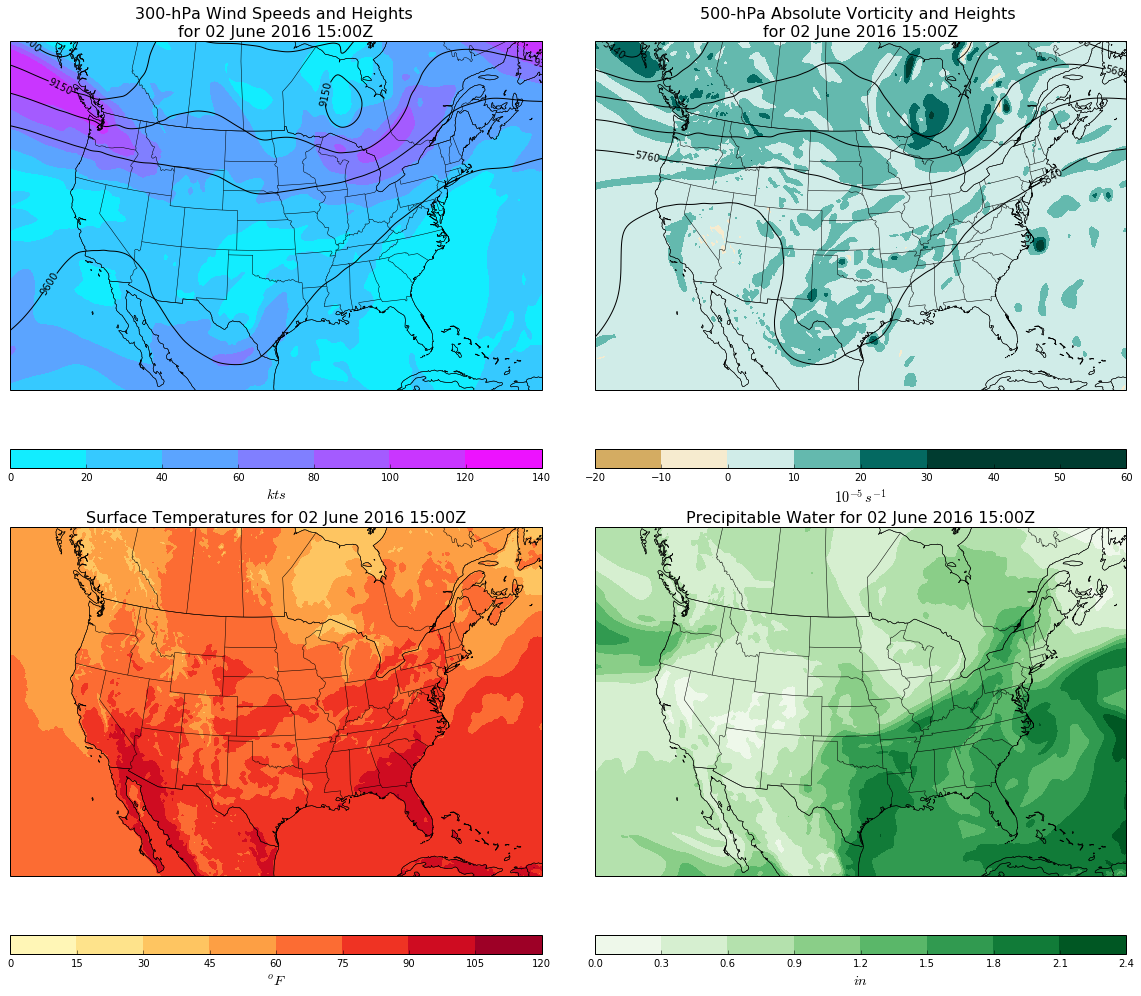

In [22]:
import matplotlib.gridspec as gridspec

# Create the figure
fig = plt.figure(figsize=(20,15))
gs = gridspec.GridSpec(5,2, height_ratios=[1, .05, 1, .05, 0], bottom=.05, top=.95, wspace=.1)


# Upper left plot - 300-hPa winds and geopotential heights
ax1 = plt.subplot(gs[0,0], projection=crs)
plot_background(ax1)
cf1 = ax1.contourf(lon_2d, lat_2d, windspeed, cmap='cool', transform=ccrs.PlateCarree())
c1 = ax1.contour(lon_2d, lat_2d, height_vals300, colors='black', linewidth=2, transform=ccrs.PlateCarree())
plt.clabel(c1, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)

ax2 = plt.subplot(gs[1,0])
cb1 = plt.colorbar(cf1, cax=ax2, orientation='horizontal')
cb1.set_label(r'$kts$', size='x-large')
ax1.set_title('300-hPa Wind Speeds and Heights \nfor {0:%d %B %Y %H:%MZ}'.format(time_vals), fontsize=16)

# Upper right plot - 500mb absolute vorticity and geopotential heights
ax3 = plt.subplot(gs[0,1], projection=crs)
plot_background(ax3)
cf2 = ax3.contourf(lon_2d, lat_2d, vor_vals, cmap='BrBG', transform=ccrs.PlateCarree(), zorder=0, 
                   norm=plt.Normalize(-32, 32), latlon=True)
c2 = ax3.contour(lon_2d, lat_2d, height_vals500, colors='k', lw=2, transform=ccrs.PlateCarree())
plt.clabel(c2, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)

ax4 = plt.subplot(gs[1,1])
cb2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal')
cb2.set_label(r'$10^{-5}\/s^{-1}$', size='x-large')
ax3.set_title('500-hPa Absolute Vorticity and Heights \nfor {0:%d %B %Y %H:%MZ}'.format(time_vals), fontsize=16)


# Lower left plot - surface temperatures
ax5 = plt.subplot(gs[2,0], projection=crs)
plot_background(ax5)
cf3 = ax5.contourf(lon_2d, lat_2d, temp_vals, cmap='YlOrRd', transform=ccrs.PlateCarree(), zorder=0)

ax6 = plt.subplot(gs[3,0])
cb3 = plt.colorbar(cf3, cax=ax6, orientation='horizontal')
cb3.set_label(r'$^oF$', size='x-large')
ax5.set_title('Surface Temperatures for {0:%d %B %Y %H:%MZ}'.format(time_vals), fontsize=16)

# Lower right plot - precipitable water entire atmosphere
ax7 = plt.subplot(gs[2,1], projection=crs)
plot_background(ax7)
cf4 = plt.contourf(lon_2d, lat_2d, precip_vals, cmap='Greens', transform=ccrs.PlateCarree(), zorder=0)

ax8 = plt.subplot(gs[3,1])
cb4 = plt.colorbar(cf4, cax=ax8, orientation='horizontal')
cb4.set_label(r'$in$', size='x-large')
ax7.set_title('Precipitable Water for {0:%d %B %Y %H:%MZ}'.format(time_vals), fontsize=16)

#Display the plot
plt.show()